# Imports and Preparing the data of behavior.tsv and news.tsv #

In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import re
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import IncrementalPCA, PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

# Load the data
base_path = Path.cwd()
news_path = base_path / 'news.tsv'
behaviors_path = base_path / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t', names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Preprocessing with Data Cleaning Remove duplicates and Text cleaning

In [2]:
# Data Cleaning
# Check if attributes such as Category, Subcategory, Title, and Abstract in news.tsv are complete.
# Remove news items with many missing values or replace them with:
# Category: unknown
# Subcategory: general
# Title and Abstract: a placeholder text like "Missing Data."
# For behaviors.tsv, remove users with missing or empty history.
news.fillna({'category': 'unknown', 'subcategory': 'general', 'title': 'Missing Title', 'abstract': 'Missing Abstract'}, inplace=True)
news.dropna(subset=['category', 'subcategory', 'title', 'abstract'], inplace=True)
behaviors.dropna(subset=['history', 'impressions'], inplace=True)

# Remove duplicates
# Remove news items in news.tsv that have the same values for Title and Abstract.
# Remove duplicate impressions (Impression ID) in behaviors.tsv
news.drop_duplicates(subset=['title', 'abstract'], inplace=True)
behaviors.drop_duplicates(subset=['impression_id'], inplace=True)

# Text cleaning
# Break down Title and Abstract into tokens:
# Remove special characters, numbers, and HTML.
# Convert all words to lowercase.
# Remove stopwords (e.g., using nltk or spacy).
# Perform lemmatization to reduce words to their base form.
def clean_text(text):
    """Clean text by removing special characters, numbers, and converting to lowercase."""
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'s", " is", text)
    
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text.lower()

def remove_stopwords_and_lemmatize(text):
    """Remove stopwords and perform basic stemming/lemmatization."""
    stopwords = set([
        'the', 'and', 'is', 'in', 'to', 'of', 'a', 'an', 'on', 'for', 'with', 'as', 'by', 'at', 'from', 'this',
        'that', 'it', 'or', 'but', 'not', 'be', 'are', 'was', 'were', 'can', 'will', 'would', 'should', 'has', 'have',
        'had', 'do', 'does', 'did', 'which', 'if', 'then', 'than', 'so', 'such', 'there', 'about', 'into', 'over', 'after'
    ])
    words = text.split()
    # Basic lemmatization (remove plural "s")
    lemmatized = [word[:-1] if word.endswith('s') else word for word in words]  
    return " ".join(word for word in lemmatized if word not in stopwords)

def preprocess_text(text):
    """Full preprocessing pipeline: clean text, remove stopwords, and lemmatize."""
    cleaned_text = clean_text(text)
    return remove_stopwords_and_lemmatize(cleaned_text)

def preprocess_text_parallel(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    return processed_texts

# Clean Title and Abstract
news['clean_title'] = preprocess_text_parallel(news['title'])
news['clean_abstract'] = preprocess_text_parallel(news['abstract'])

# Data Preparation with TF-IDF, One-hot and PCA

In [3]:
#TF-IDF
# Convert clean_title and clean_abstract into numerical vectors
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_title = tfidf_vectorizer.fit_transform(news['clean_title'])
tfidf_abstract = tfidf_vectorizer.fit_transform(news['clean_abstract'])

# Combine sparse matrices
news_features = hstack([tfidf_title, tfidf_abstract])

# One-hot encode categories and subcategories
category_encoded = pd.get_dummies(news['category'])
subcategory_encoded = pd.get_dummies(news['subcategory'])

# Combine categorical and TF-IDF features
final_features = hstack([news_features, category_encoded.values, subcategory_encoded.values])

# PCA for faster processing instead of t-SNE for better visualization
pca = IncrementalPCA(n_components=50, batch_size=1000)
reduced_features = pca.fit_transform(news_features)

# Elbow method to get best cluster amount

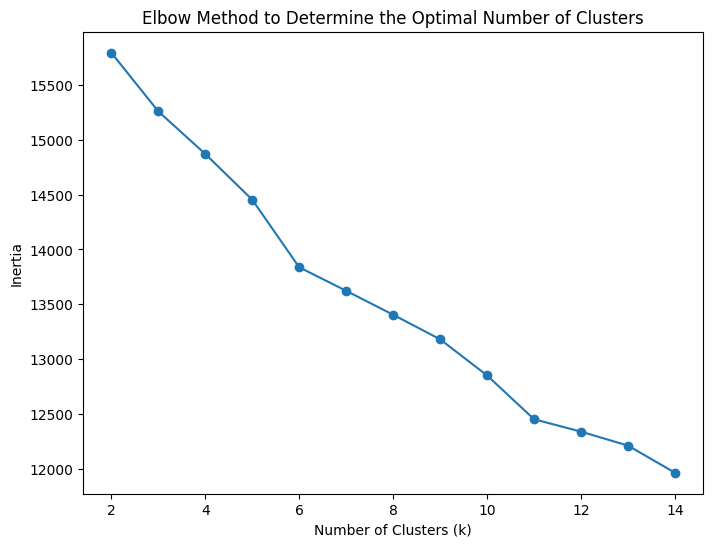

In [4]:
# Elbow method
inertia_values = []
cluster_range = range(2, 15)  # Test cluster numbers between 2 and 14

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    inertia_values.append(kmeans.inertia_)

# Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine the Optimal Number of Clusters')
plt.show()

# Silhouette analysis to get best cluster amount

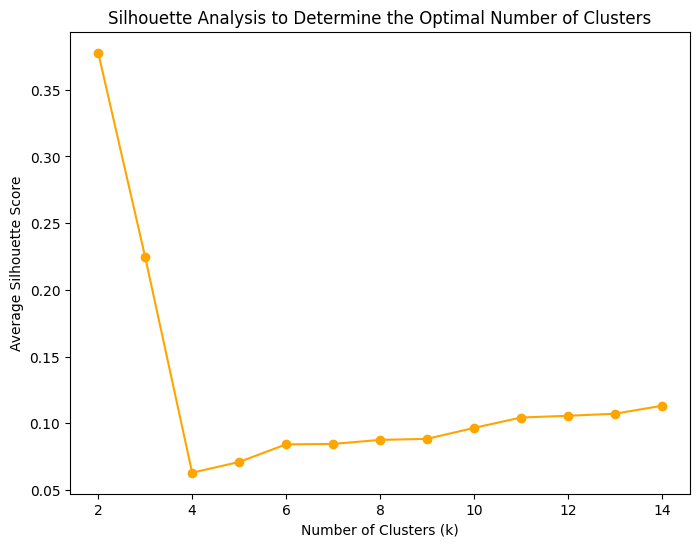

In [5]:
# Silhouette analysis
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_features)
    silhouette_avg = silhouette_score(reduced_features, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis to Determine the Optimal Number of Clusters')
plt.show()

# Hierarchical Clustering with Dendrogram

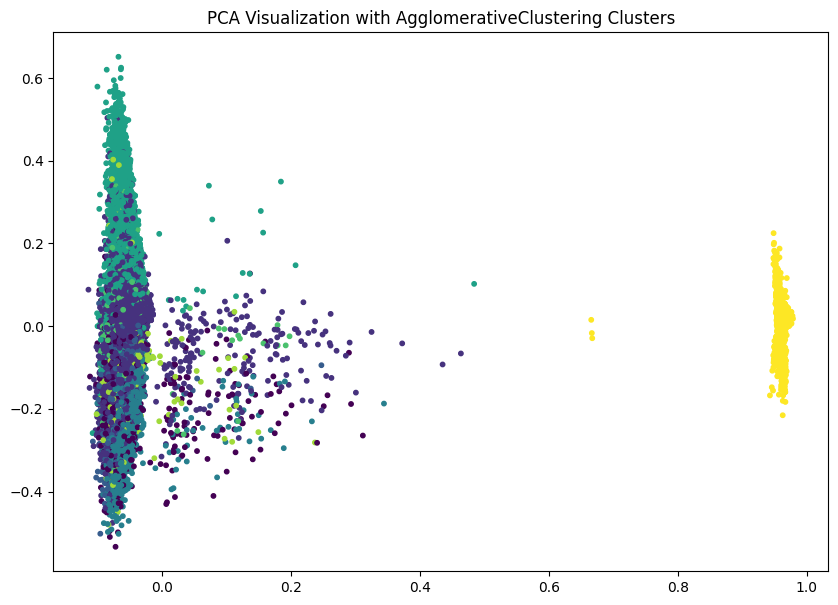

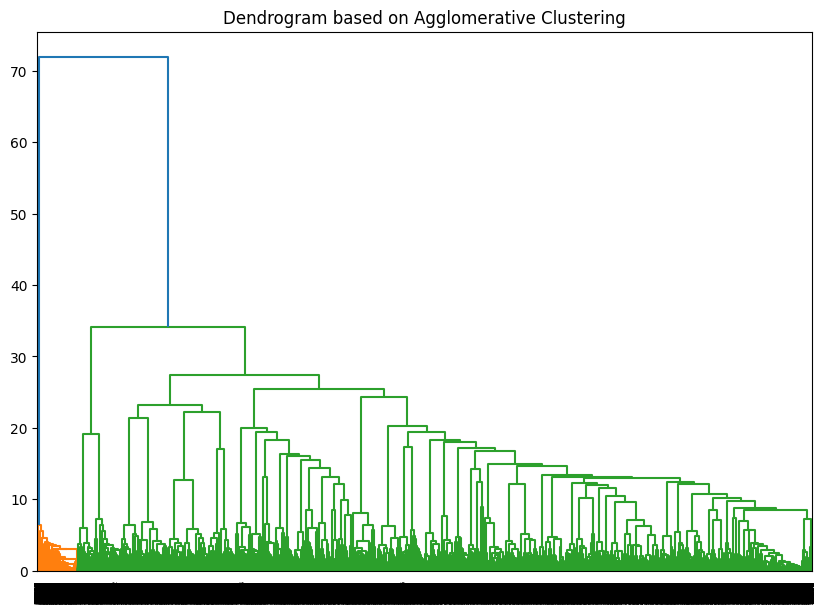

In [6]:
optimal_k = 8

agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels = agglo.fit_predict(reduced_features)

# PCA for Visualization of Clusters (Agglomerative Clustering)
pca_vis = PCA(n_components=2)
pca_features = pca_vis.fit_transform(reduced_features)

# Plot PCA visualization
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
plt.title(f'PCA Visualization with AgglomerativeClustering Clusters')
plt.show()

# If you still want a dendrogram like in scipy, you can visualize the clustering results
# by creating a dendrogram based on AgglomerativeClustering distances:
Z = linkage(reduced_features, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram based on Agglomerative Clustering')
plt.show()

# KMeans Visualization with PCA

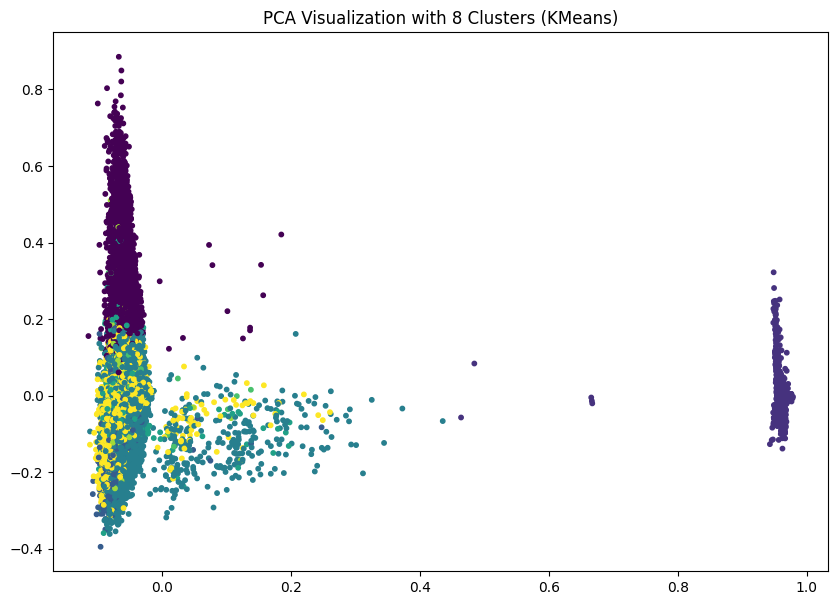

In [7]:
# Clustering with MiniBatchKMeans
optimal_k = 8

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
news['cluster'] = kmeans.fit_predict(reduced_features)

# PCA for Visualization
pca_vis = IncrementalPCA(n_components=2)
pca_features = pca_vis.fit_transform(reduced_features)

# PCA Visualization
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
plt.title(f'PCA Visualization with {optimal_k} Clusters (KMeans)')
plt.show()


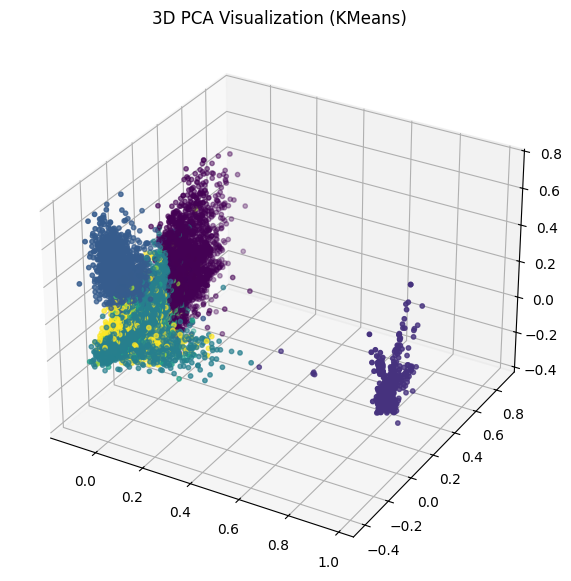

In [8]:
# PCA mit 3 Dimensionen
pca_3d = IncrementalPCA(n_components=3)
pca_features_3d = pca_3d.fit_transform(reduced_features)

# 3D-Visualisierung
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_features_3d[:, 0], 
    pca_features_3d[:, 1], 
    pca_features_3d[:, 2], 
    c=news['cluster'], cmap='viridis', s=10
)

ax.set_title('3D PCA Visualization (KMeans)')
plt.show()


C:\Users\nicla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


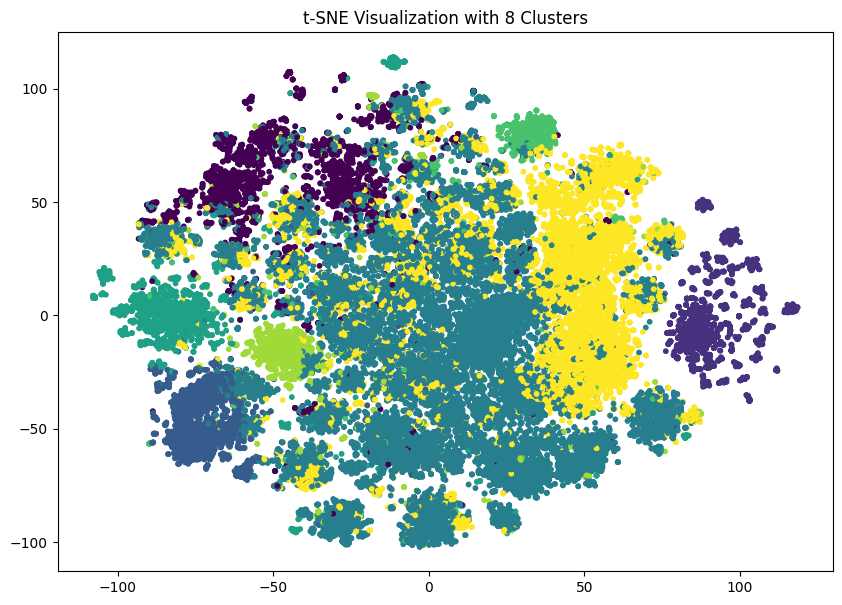

In [9]:
# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_features = tsne.fit_transform(reduced_features)

# t-SNE Visualization
plt.figure(figsize=(10, 7))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
plt.title(f't-SNE Visualization with {optimal_k} Clusters')
plt.show()


# DBSCAN Clustering

In [10]:
# Check the number of rows in the news DataFrame
num_rows = news.shape[0]
print(f"The number of rows in the news DataFrame is: {num_rows}")


The number of rows in the news DataFrame is: 50669


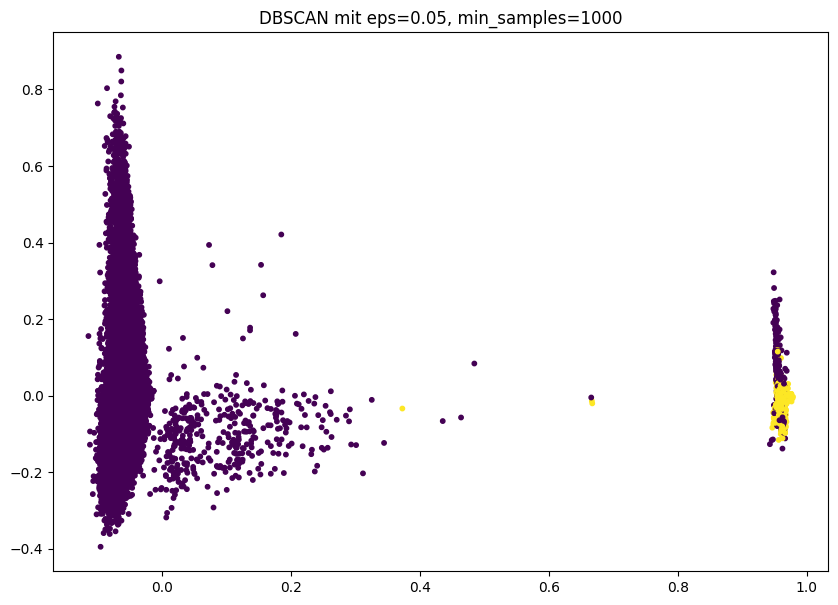

Parameter eps=0.05, min_samples=1000
{-1: 48449, 0: 2220}

----------------------------------------



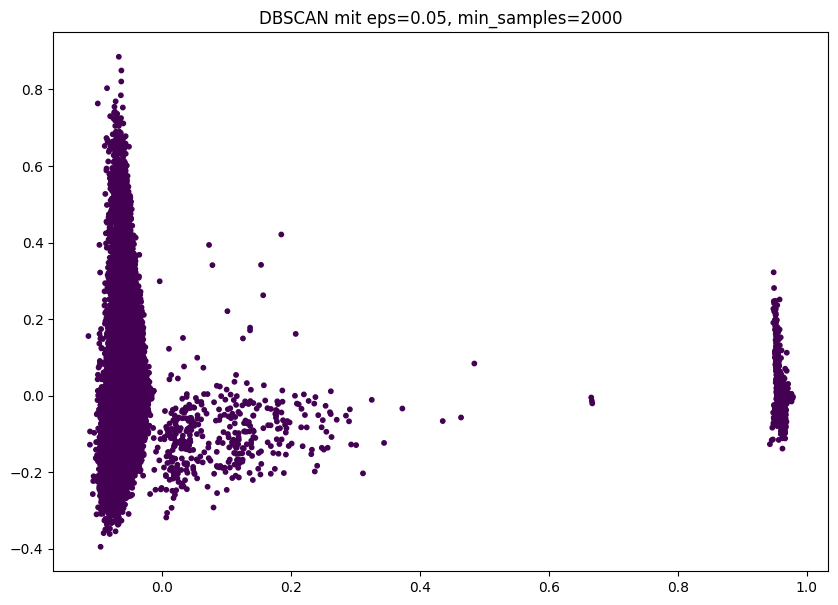

Parameter eps=0.05, min_samples=2000
{-1: 50669}

----------------------------------------



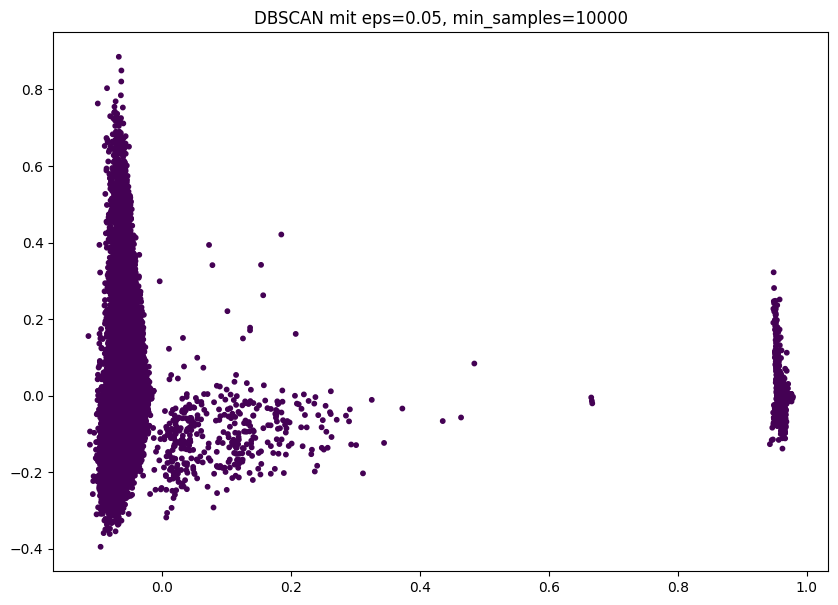

Parameter eps=0.05, min_samples=10000
{-1: 50669}

----------------------------------------



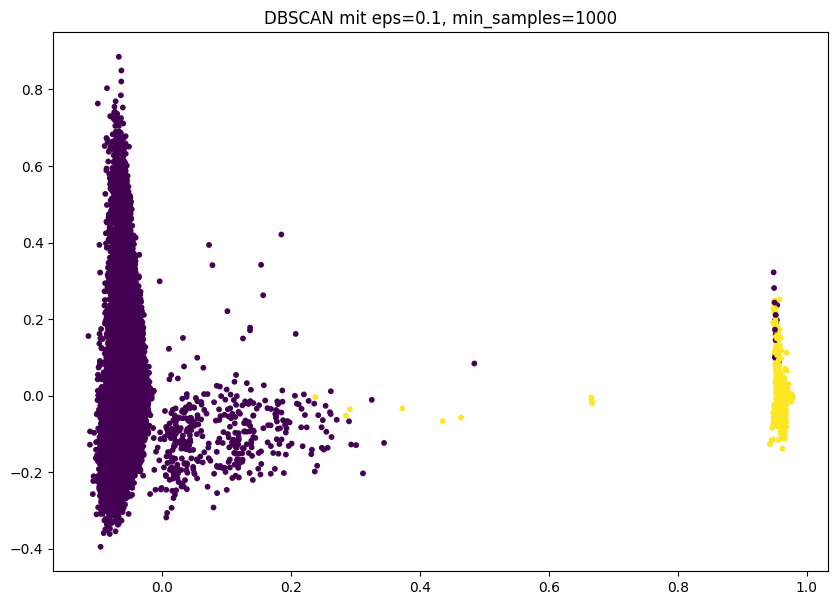

Parameter eps=0.1, min_samples=1000
{-1: 48027, 0: 2642}

----------------------------------------



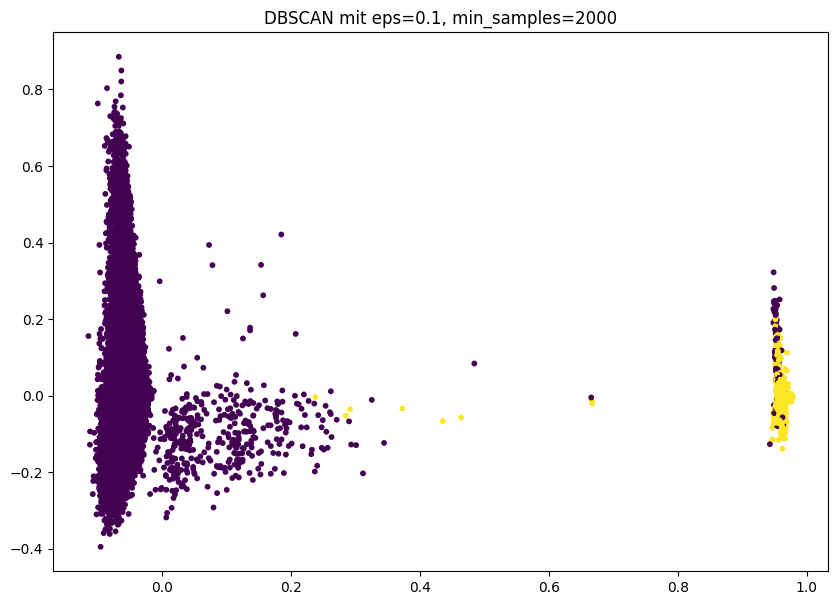

Parameter eps=0.1, min_samples=2000
{-1: 48162, 0: 2507}

----------------------------------------



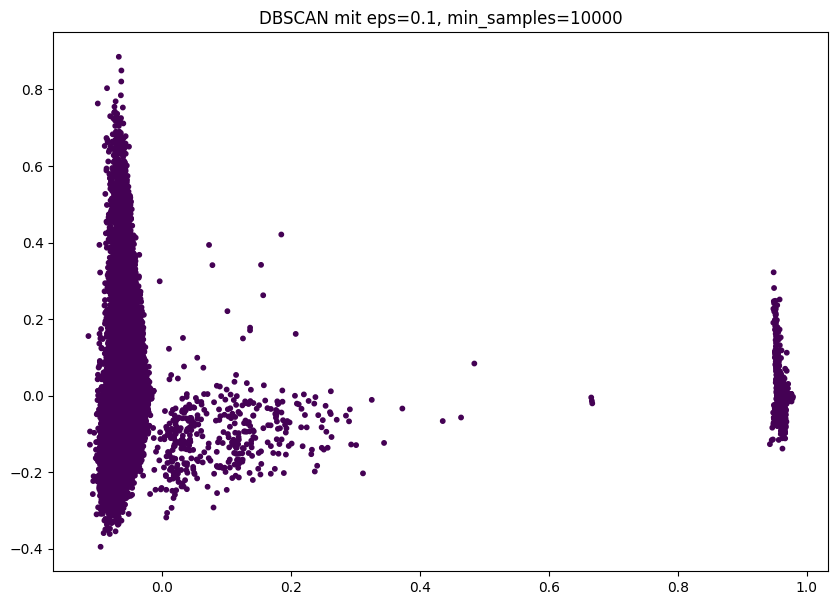

Parameter eps=0.1, min_samples=10000
{-1: 50669}

----------------------------------------



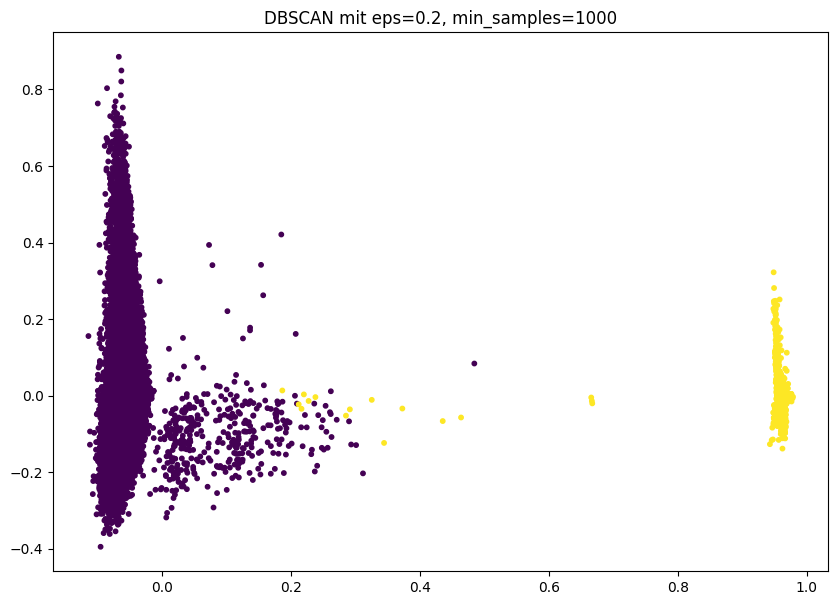

Parameter eps=0.2, min_samples=1000
{-1: 47998, 0: 2671}

----------------------------------------



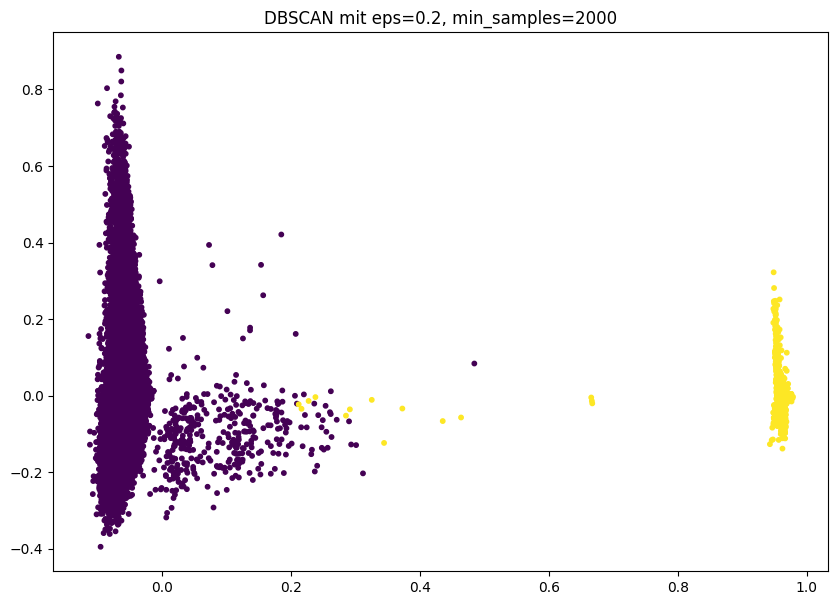

Parameter eps=0.2, min_samples=2000
{-1: 48000, 0: 2669}

----------------------------------------



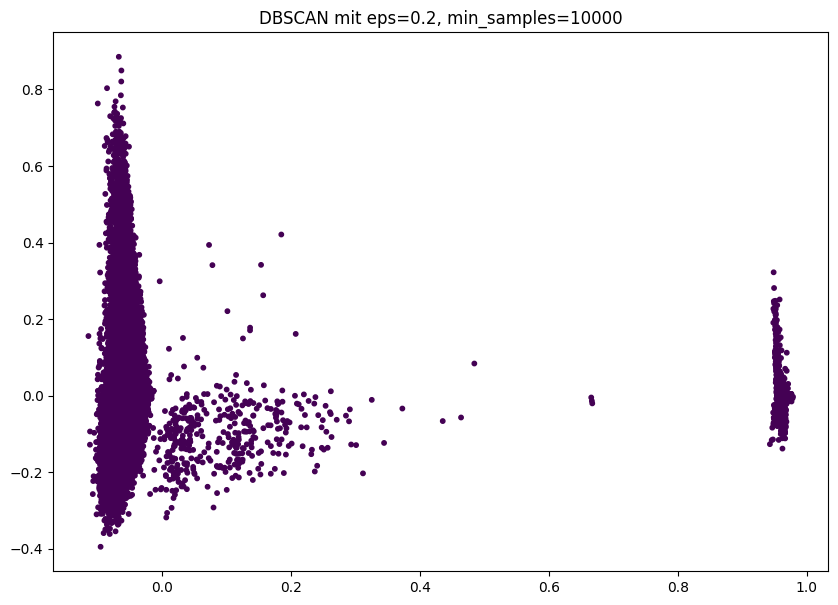

Parameter eps=0.2, min_samples=10000
{-1: 50669}

----------------------------------------



In [11]:
# DBSCAN Clustering
eps_values = [0.05, 0.1, 0.2]
min_samples_values = [1000, 2000, 10000]

# Small eps values (like 0.05) lead to many small, dense clusters and a high number of outliers, which might be too restrictive for your dataset.
# Medium eps values (e.g., 0.1) offer a better balance and create several larger clusters. This might be a better choice as it results in fewer outliers and more differentiated clusters.
# Large eps values (e.g., 0.2) tend to group most data points into one cluster, indicating that eps=0.2 is too large to form meaningful clusters.

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(reduced_features)

        plt.figure(figsize=(10, 7))
        plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
        plt.title(f'DBSCAN mit eps={eps}, min_samples={min_samples}')
        plt.show()

        unique, counts = np.unique(labels, return_counts=True)
        print(f'Parameter eps={eps}, min_samples={min_samples}')
        print(dict(zip(unique, counts)))
        print("\n" + "-"*40 + "\n")

# Elements an Categories per Clustering

In [12]:
# KMeans

# Count the number of articles in each cluster
cluster_counts = news['cluster'].value_counts().sort_index()

# Initialize dictionaries to store cluster information
cluster_examples = {}
cluster_categories = {}

# Iterate through each cluster
for cluster_id in sorted(news['cluster'].unique()):
    cluster_data = news[news['cluster'] == cluster_id]
    
    # Save 10 example articles (title and category)
    cluster_examples[cluster_id] = cluster_data[['title', 'category']].head(10)
    
    # Count the categories within the cluster
    cluster_categories[cluster_id] = cluster_data['category'].value_counts()

# Print the results
print("Number of articles per cluster:")
print(cluster_counts)

for cluster_id in cluster_examples:
    print(f"\nCluster {cluster_id}:")
    print("Examples:")
    print(cluster_examples[cluster_id])
    print("\nCategories in the cluster:")
    print(cluster_categories[cluster_id])


Number of articles per cluster:
cluster
0     4116
1     2660
2     2461
3    26568
4     2427
5      937
6     1415
7    10085
Name: count, dtype: int64

Cluster 0:
Examples:
                                                title      category
1                       50 Worst Habits For Belly Fat        health
4   How to Get Rid of Skin Tags, According to a De...        health
6   It's been Orlando's hottest October ever so fa...       weather
10  50 Foods You Should Never Eat, According to He...        health
12  25 Biggest Grocery Store Mistakes Making You G...        health
25                10 Things You Never Knew About Owls     lifestyle
26  25 Last-Minute Ideas That Will Absolutely Save...  foodanddrink
34  20 Must-Try Gravy Recipes for Your Thanksgivin...  foodanddrink
39  5 Things You Probably Shouldn't Be Buying from...     lifestyle
44  These Cranberry Sauce Recipes Are Perfect for ...  foodanddrink

Categories in the cluster:
category
foodanddrink     764
lifestyle        6

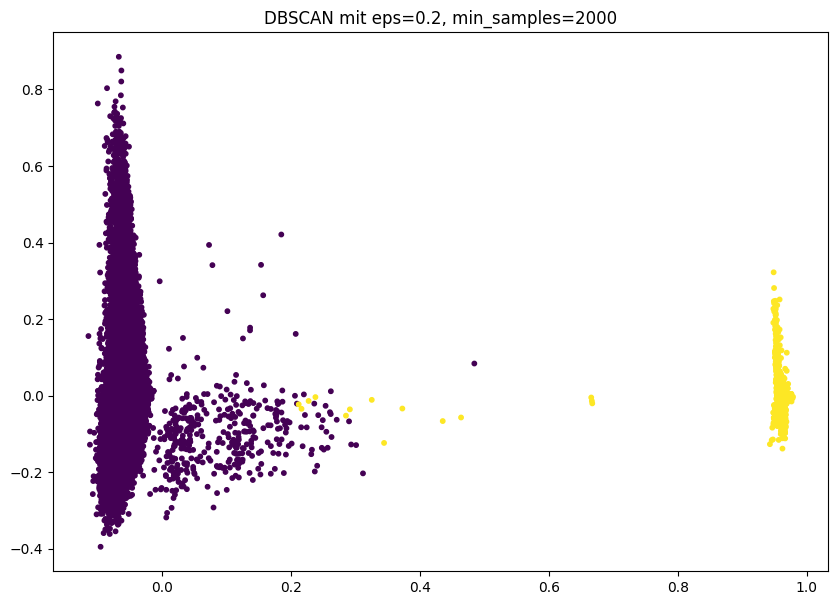

Parameter eps=0.2, min_samples=2000
{-1: 48000, 0: 2669}

----------------------------------------

Number of articles per DBSCAN cluster:
{-1: 48000, 0: 2669}

Cluster -1:
Examples:
                                               title       category
0  The Brands Queen Elizabeth, Prince Charles, an...      lifestyle
1                      50 Worst Habits For Belly Fat         health
2  The Cost of Trump's Aid Freeze in the Trenches...           news
3  I Was An NBA Wife. Here's How It Affected My M...         health
4  How to Get Rid of Skin Tags, According to a De...         health
5  Should NFL be able to fine players for critici...         sports
6  It's been Orlando's hottest October ever so fa...        weather
7  Chile: Three die in supermarket fire amid prot...           news
8  Best PS5 games: top PlayStation 5 titles to lo...  entertainment
9     How to report weather-related closings, delays           news

Categories in the cluster:
category
news             15067
sports   

In [13]:
# DBSCAN
best_eps = 0.2
best_samples = 2000


dbscan = DBSCAN(eps= best_eps, min_samples=best_samples, metric='cosine')
labels = dbscan.fit_predict(reduced_features)

plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
plt.title(f'DBSCAN mit eps={best_eps}, min_samples={best_samples}')
plt.show()

unique, counts = np.unique(labels, return_counts=True)
print(f'Parameter eps={best_eps}, min_samples={best_samples}')
print(dict(zip(unique, counts)))
print("\n" + "-"*40 + "\n")


# Count the number of articles in each DBSCAN cluster
unique_labels = np.unique(labels)  # labels = DBSCAN output labels
cluster_counts_dbscan = {label: (labels == label).sum() for label in unique_labels}

# Initialize dictionaries to store cluster information
cluster_examples_dbscan = {}
cluster_categories_dbscan = {}

# Iterate through each DBSCAN cluster
for cluster_id in unique_labels:
    cluster_data = news[labels == cluster_id]
    
    # Save 10 example articles (title and category)
    cluster_examples_dbscan[cluster_id] = cluster_data[['title', 'category']].head(10)
    
    # Count the categories within the cluster
    cluster_categories_dbscan[cluster_id] = cluster_data['category'].value_counts()

# Print the results
print("Number of articles per DBSCAN cluster:")
print(cluster_counts_dbscan)

for cluster_id in cluster_examples_dbscan:
    print(f"\nCluster {cluster_id}:")
    print("Examples:")
    print(cluster_examples_dbscan[cluster_id])
    print("\nCategories in the cluster:")
    print(cluster_categories_dbscan[cluster_id])

In [14]:
# Hybrid Recommendation System using BERT-based Embeddings and Collaborative Filtering

# In this cell, we are going to extend our analysis by developing a hybrid recommendation system.
# We will combine content-based recommendations using BERT-based text embeddings with user behavior data.
# This approach enables us to provide recommendations that take into account both the semantic information of news articles (content) and
# user preferences derived from their historical behaviors (collaborative filtering).

# Key Steps:
# 1. Data Loading and Cleaning
# 2. Text Preprocessing
# 3. Obtain embeddings for news articles using a pre-trained BERT model.
# 4. Compute similarity scores between articles based on these embeddings to provide content-based recommendations.
# 5. Combine the similarity information with user behavior data to generate personalized hybrid recommendations.
# 6. Visualize the hybrid recommendations to better understand the effectiveness of the approach.

# Check if GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Apply text cleaning to Title and Abstract
print("Preprocessing text data...")
news['clean_title'] = news['title'].apply(preprocess_text)
news['clean_abstract'] = news['abstract'].apply(preprocess_text)

# Combine the cleaned title and abstract
news['combined_text'] = news['clean_title'] + ' ' + news['clean_abstract']

# Verify that there are no NaN values in 'combined_text'
assert news['combined_text'].isna().sum() == 0, "There are NaN values in 'combined_text'"

# Initialize BERT tokenizer and model
print("Loading BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

Preprocessing text data...
Loading BERT model...


C:\Users\nicla\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renam

In [ ]:
# Load the saved embeddings
#loaded_embeddings = np.load('news_embeddings.npy')
#print("Embeddings loaded successfully.")

In [16]:
import torch.nn.functional as F

# Function to get BERT embeddings for text
def get_bert_embedding(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        text = ""
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token representation as the embedding
    return outputs.last_hidden_state[:, 0, :]

# Generate embeddings for news articles
print("Generating BERT embeddings for news articles...")
news_embeddings_list = [get_bert_embedding(text) for text in news['combined_text'].tolist()]
news_embeddings = torch.cat(news_embeddings_list, dim=0)  # Shape: (num_articles, embedding_dim)

# Normalize embeddings
print("Normalizing embeddings...")
news_embeddings = F.normalize(news_embeddings, p=2, dim=1)  # L2 normalization

Generating BERT embeddings for news articles...
Normalizing embeddings...


In [17]:
# Collaborative filtering component: create user-item interaction matrix
print("Creating user-item interaction matrix...")
user_ids = behaviors['user_id'].unique()
news_ids = news['news_id'].unique()

# Create mappings from IDs to indices
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
news_id_to_index = {news_id: idx for idx, news_id in enumerate(news_ids)}

# Initialize empty lists for COO format
row_indices = []
col_indices = []
data = []

for _, row in behaviors.iterrows():
    user_id = row['user_id']
    impressions = row['impressions'].split()
    for impression in impressions:
        if '-' in impression:
            news_id, clicked = impression.split('-')
            if news_id in news_id_to_index and clicked == '1':  # Mark as clicked
                user_idx = user_id_to_index[user_id]
                news_idx = news_id_to_index[news_id]
                row_indices.append(user_idx)
                col_indices.append(news_idx)
                data.append(1)

num_users = len(user_ids)
num_items = len(news_ids)

# Create sparse interaction matrix in COO format
indices = torch.LongTensor([row_indices, col_indices])  # Shape: [2, num_interactions]
values = torch.FloatTensor(data)
user_item_matrix = torch.sparse_coo_tensor(indices, values, (num_users, num_items)).to(device)

Creating user-item interaction matrix...


In [18]:
# Hybrid Recommendation: Combining content similarity and user interaction
alpha = 0.5  # Weight for combining collaborative and content-based recommendations
K = 10       # Number of recommendations per user

print("Generating hybrid recommendations...")
hybrid_recommendations = {}

num_users = user_item_matrix.shape[0]
num_items = news_embeddings.shape[0]
embedding_dim = news_embeddings.shape[1]

# Prepare item factors from user-item interactions
item_user_matrix = user_item_matrix.transpose(0, 1).to_dense()  # Shape: (num_items, num_users)

# Normalize item-user matrix
item_user_norms = item_user_matrix.norm(p=2, dim=1, keepdim=True)
item_user_matrix = item_user_matrix / (item_user_norms + 1e-8)  # Avoid division by zero

# Move item_user_matrix to GPU if not already
item_user_matrix = item_user_matrix.to(device)

for user_idx in range(num_users):
    # Get the user interaction vector
    user_interactions = user_item_matrix[user_idx].to_dense()  # Shape: (num_items,)
    interacted_items = user_interactions.nonzero(as_tuple=False).squeeze(1)

    # Skip users with no interactions
    if interacted_items.numel() == 0:
        continue

    # Compute content-based scores
    # Average the embeddings of items the user has interacted with
    user_content_embedding = news_embeddings[interacted_items].mean(dim=0, keepdim=True)  # Shape: (1, embedding_dim)
    user_content_embedding = F.normalize(user_content_embedding, p=2, dim=1)

    # Compute content scores (cosine similarity)
    content_scores = torch.mm(news_embeddings, user_content_embedding.t()).squeeze(1)  # Shape: (num_items,)

    # Compute collaborative filtering scores
    # Average the item-user vectors of items the user has interacted with
    user_collaborative_vector = item_user_matrix[interacted_items].mean(dim=0, keepdim=True)  # Shape: (1, num_users)
    user_collaborative_vector = F.normalize(user_collaborative_vector, p=2, dim=1)

    # Compute collaborative scores (cosine similarity)
    collaborative_scores = torch.mm(item_user_matrix, user_collaborative_vector.t()).squeeze(1)  # Shape: (num_items,)

    # Hybrid score: weighted combination
    hybrid_scores = alpha * content_scores + (1 - alpha) * collaborative_scores

    # Exclude already interacted items from recommendations
    hybrid_scores[interacted_items] = -float('Inf')  # Set to negative infinity to avoid recommending

    # Get top K recommendations for this user
    _, top_indices = torch.topk(hybrid_scores, K)
    recommended_news_ids = [news_ids[idx] for idx in top_indices.cpu().numpy()]

    # Store the recommendations
    user_id = user_ids[user_idx]
    hybrid_recommendations[user_id] = recommended_news_ids

print("Hybrid recommendation generation completed.")

Generating hybrid recommendations...
Hybrid recommendation generation completed.


In [19]:
# Output some sample recommendations
print("Sample hybrid recommendations for users:")
sample_users = list(hybrid_recommendations.keys())[:5]
for user_id in sample_users:
    recommendations = hybrid_recommendations[user_id]
    print(f"User: {user_id}, Recommendations: {recommendations}")

Sample hybrid recommendations for users:
User: U13740, Recommendations: ['N36569', 'N16732', 'N65049', 'N63832', 'N7296', 'N13077', 'N59612', 'N22364', 'N55894', 'N60118']
User: U91836, Recommendations: ['N52947', 'N62360', 'N2384', 'N42595', 'N350', 'N39317', 'N43806', 'N1034', 'N54595', 'N63970']
User: U73700, Recommendations: ['N12552', 'N32829', 'N1680', 'N23086', 'N52622', 'N59713', 'N12842', 'N51346', 'N47182', 'N50104']
User: U34670, Recommendations: ['N55689', 'N49279', 'N33619', 'N63970', 'N49180', 'N35729', 'N42977', 'N50675', 'N287', 'N36789']
User: U8125, Recommendations: ['N9836', 'N51853', 'N14935', 'N64323', 'N27490', 'N58155', 'N38522', 'N6008', 'N5697', 'N62289']


Visualizing hybrid recommendations...


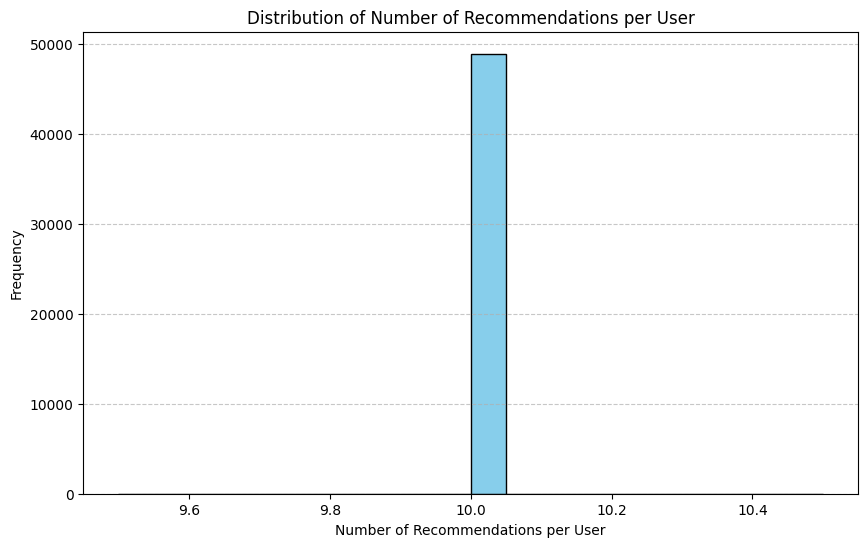

In [20]:
# Visualization of Hybrid Recommendations
print("Visualizing hybrid recommendations...")
recommendation_counts = [len(recommendations) for recommendations in hybrid_recommendations.values()]

plt.figure(figsize=(10, 6))
plt.hist(recommendation_counts, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Recommendations per User')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Recommendations per User')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Generating content similarity heatmap for a subset of articles...


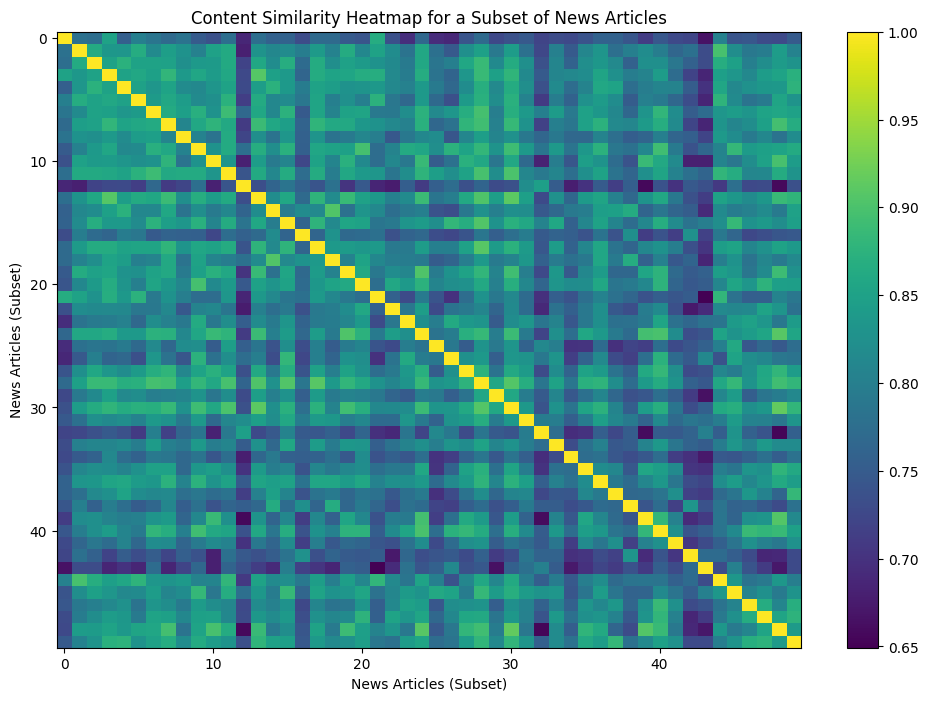

In [21]:
# Additional visualization: Content Similarity Heatmap for a Subset of Articles

print("Generating content similarity heatmap for a subset of articles...")

# Select a subset of articles
subset_size = 50  # Adjust as needed based on available memory
subset_indices = np.random.choice(news_embeddings.shape[0], size=subset_size, replace=False)
subset_embeddings = news_embeddings[subset_indices]

# Compute similarity matrix for the subset
with torch.no_grad():
    # Compute cosine similarity
    similarity_matrix = torch.mm(subset_embeddings, subset_embeddings.t())
    # Convert to CPU and NumPy array
    similarity_matrix = similarity_matrix.cpu().numpy()

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('News Articles (Subset)')
plt.ylabel('News Articles (Subset)')
plt.title('Content Similarity Heatmap for a Subset of News Articles')
plt.show()

In [22]:
# Move embeddings to CPU and convert to NumPy
news_embeddings_cpu = news_embeddings.cpu().numpy()

# Save the calculated embeddings
print("Saving embeddings to 'news_embeddings.npy'...")
np.save('news_embeddings.npy', news_embeddings_cpu)
print("Embeddings saved successfully.")

Saving embeddings to 'news_embeddings.npy'...
Embeddings saved successfully.


In [23]:
# Create a DataFrame from the hybrid_recommendations dictionary
recommendations_df = pd.DataFrame({
    'user_id': list(hybrid_recommendations.keys()),
    'recommended_news_ids': list(hybrid_recommendations.values())
})

# Define the file path where you want to save the recommendations
output_file = 'hybrid_recommendations.csv'

# Save the DataFrame to a CSV file
recommendations_df.to_csv(output_file, index=False)

print(f"Hybrid recommendations have been saved to {output_file}")

Hybrid recommendations have been saved to hybrid_recommendations.csv


In [24]:
# Load necessary libraries
import numpy as np
import pandas as pd
import ast

# Load the news DataFrame
news_path = 'news.tsv'
news_columns = ['news_id', 'category', 'subcategory', 'title', 'abstract',
                'url', 'title_entities', 'abstract_entities']
news = pd.read_csv(news_path, sep='\t', names=news_columns)

# Load the saved recommendations
recommendations_df = pd.read_csv('hybrid_recommendations.csv')

# Convert the 'recommended_news_ids' string representation back to lists
recommendations_df['recommended_news_ids'] = recommendations_df['recommended_news_ids'].apply(ast.literal_eval)

# Select 5 sample users
sample_users = recommendations_df.sample(5, random_state=42)

# For each sample user, print the 10 recommendations with title and abstract
for idx, row in sample_users.iterrows():
    user_id = row['user_id']
    recommended_news_ids = row['recommended_news_ids']
    print(f"\nUser ID: {user_id}")
    print("Top 10 Recommendations:")
    for news_id in recommended_news_ids:
        # Find the news article in the news DataFrame
        news_article = news[news['news_id'] == news_id]
        if not news_article.empty:
            title = news_article['title'].values[0]
            abstract = news_article['abstract'].values[0]
            print(f"\nNews ID: {news_id}")
            print(f"Title: {title}")
            print(f"Abstract: {abstract}")
        else:
            print(f"\nNews ID: {news_id} not found in news DataFrame.")


User ID: U15035
Top 10 Recommendations:

News ID: N19153
Title: Broncos at Vikings odds: Denver 10.5-point underdogs to Minnesota
Abstract: The Denver Broncos are huge road underdogs to the Minnesota Vikings in Week 11. The latest shows a 10.5 point spread on this game.

News ID: N13579
Title: Chris Paul feels he got 'stabbed in the back' with trade from Rockets
Abstract: Paul has been traded three times in his career (four if you include the Lakers veto).

News ID: N18870
Title: Here Are the Biggest Deals We're Anticipating for Black Friday
Abstract: The Black Friday deals for 2019 have already begun leaking out. Get a sneak peek at what to expect from popular retailers like Costco, Walmart, and Best Buy. Browse our guide and use it to plan your attack for the biggest shopping event of the year.

News ID: N49712
Title: Wisconsin bus driver saves children wandering in snow, as deadly Arctic air mass grips US
Abstract: As bitter cold took hold across the Midwest earlier this week, a sh